In [66]:
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
import numpy as np
import matplotlib.pyplot as plt

### regression

Let's start by using `keras` to make a neural network for a simple regression task where both the input and the output as 1-dimensional. Below is some code that will produce the dataset for you to train on.

Here are some general steps to follow:
1. Define your model by passing `tfk.Sequential` a list of layers (found in `tf.keras.layers`, which is already imported for you by the shorter name `tfkl`, since you will use this module many times.
2. Your first layers should be a `tfkl.Input` layer that specifies the shape of the input (it will automatically include an empty first dimension with size `None` as a placehold for the batch size).
3. The rest of your layers should be `tfkl.Dense` layers; you will be to specify the number of neurons/units as well as the activation function (you can find those in `tf.nn`, and you can use `None` for a "linear" activation function, $f(x)=x$). Make sure you pick an output function that makes sense for this prediction task!
4. Choose an appropriate optimizer from `tfk.optimizers` and an appropriate loss function from `tfk.losses` (both are classes that wil need to be initialized), and then pass them to `model.compile` to compile your model.
5. Call `model.fit` to fit your model and collect the results
6. Plot your training curve (loss vs training step)
7. Call your model (`model(...)`) on a grid of inputs (code to make the grid provided) and plot the relationship your model learned against the true relationship (defined as `f` in the code below).

https://www.tensorflow.org/guide/keras/sequential_model

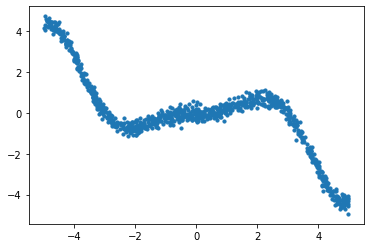

In [67]:
def regression_data(N):
    x = np.random.uniform(low=-5.0, high=5.0, size=(N, 1)).astype(np.float32)
    e = 0.2 * np.random.normal(size=(N, 1)).astype(np.float32)
    f = lambda x: 0.2 * x**2 * np.sin(2 * np.pi * x / 6)
    y = f(x) + e
    return x, y

N = 1000
x_train, y_train = regression_data(int(N*0.8))
x_test, y_test = regression_data(int(N*0.2))

plt.scatter(np.concatenate((x_train,x_test),axis=0), np.concatenate((y_train,y_test),axis=0), s=10)
plt.show()

In [68]:
model = tfk.Sequential(
    [
        tfkl.Input(shape=(1,)), #input layer
        tfkl.Dense(10, activation=tf.nn.tanh), #start from large number features and narrow down the layer
        tfkl.Dense(6, activation=tf.nn.tanh),
        #tfkl.Dense(3,activation=None) #two linear layer is unnecessarily complicated
        tfkl.Dense(1, activation=None) #output layer: linear activation function
    ]
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 10)                20        
_________________________________________________________________
dense_16 (Dense)             (None, 6)                 66        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 7         
Total params: 93
Trainable params: 93
Non-trainable params: 0
_________________________________________________________________


In [69]:
loss = tfk.losses.MeanSquaredError()
opt = tfk.optimizers.Adam()

model.compile(optimizer=opt, loss=loss)

In [70]:
cbs = [tfk.callbacks.EarlyStopping(min_delta=0.01,patience=2)] 
#when it stops going down (when decrease<min(delta), patience=3 means 3 times for not decreasing) 

ds_train = tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(32).repeat().prefetch(10) 
ds_test = tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(100).repeat().prefetch(10) 
#batch my large dataset into 32 bits batch-size which aligns with my computer, and repeat it. prefetch(10) means pre-grab 10 in cpu and then pass it to gpu


last two epochs should be below min_delta=0.01

In [71]:
results = model.fit(ds_train,steps_per_epoch=100,epochs=10000,callbacks=cbs,verbose=1,validation_data=ds_test,validation_steps=1)
#results = model.fit(x,y,epochs=1000,batch_size=x.shape[0],verbose=0,callbacks=cbs,validation_split=0.2)

# what is batch?
# usually for big dataset, we should get small batch-size on it
# if your dataset is 1000 points, and your mini batch size is 100, then it'll take 10 steps to do that

# what is epochs?
# epochs how many times you run through your whole dataset

# verbose?
# verbose will turn out one line for one epoch

# callbacks earlystopping?
# Use callbacks for earlystopping at every end of epoch,
# See if loss is not decreasing in validation dataset, not on training dataset which causes overfitting
# without this, there will be many "WARNING" saying no metrics

#steps_per_epoch?
# stop in 100th step in every epoch and check callbacks earlystopping rule, not necessarily one whole dataset one epoch

#validation_steps?
# how many batches are used in one epoch 
# set it as 1 - use all of data as one batch

Epoch 1/10000
100/100 [==============================] - 0s 1ms/step - loss: 2.7564 - val_loss: 2.4770
Epoch 2/10000
100/100 [==============================] - 0s 598us/step - loss: 2.2108 - val_loss: 1.9375
Epoch 3/10000
100/100 [==============================] - 0s 644us/step - loss: 1.7073 - val_loss: 1.4479
Epoch 4/10000
100/100 [==============================] - 0s 636us/step - loss: 1.2880 - val_loss: 1.0871
Epoch 5/10000
100/100 [==============================] - 0s 663us/step - loss: 1.0121 - val_loss: 0.8734
Epoch 6/10000
100/100 [==============================] - 0s 659us/step - loss: 0.8489 - val_loss: 0.7443
Epoch 7/10000
100/100 [==============================] - 0s 654us/step - loss: 0.7402 - val_loss: 0.6544
Epoch 8/10000
100/100 [==============================] - 0s 660us/step - loss: 0.6579 - val_loss: 0.5855
Epoch 9/10000
100/100 [==============================] - 0s 682us/step - loss: 0.5916 - val_loss: 0.5308
Epoch 10/10000
100/100 [==============================] -

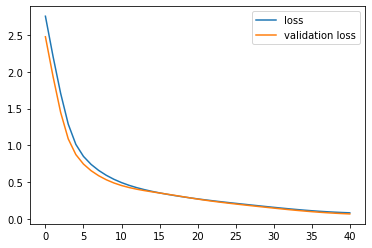

In [78]:
# check out training curve
# not only loss, but also validation_loss
plt.plot(results.history["loss"],label="loss")
plt.plot(results.history["val_loss"],label="validation loss")
plt.legend()
plt.show()

In [73]:
x_grid = np.linspace(x.min(), x.max(), 200).astype(np.float32)[:, np.newaxis] # in tensorflow, it assumes 2-d for data points, so we need np.newaxis to transform to 1-d
y_fit = model(x_grid)

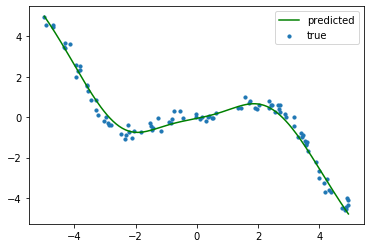

In [74]:
plt.scatter(x, y, s=10, label="true")
plt.plot(x_grid,y_fit,color="green",label="predicted")
plt.legend()
plt.show()

### binary classification

Here is another dataset that differs in two key ways from the regression example we just worked:
1. The input is now 2-dimensional
2. The targets are now binary classes

Update your model to handle both of these changes and try fitting this new data. Think about the following:
- input shape
- output function
- loss function

Since visualizing the results is a bit tricky, we have provided some code for that.

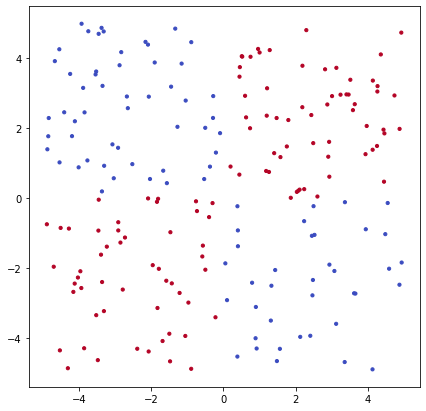

In [79]:
N = 200
def binary_classification_data(N):
    x = np.random.uniform(low=-5, high=5, size=(N, 2))
    y = (x[:, 0] * x[:, 1] > 0).astype(np.int)
    return x, y

x_train, y_train = binary_classification_data(N)
x_test, y_test = binary_classification_data(N)

plt.figure(figsize=(7, 7))
plt.scatter(x_train[:, 0], x_train[:, 1], s=10, c=y_train, cmap='coolwarm')
plt.show()

tf.nn.softplus is like relu, but more smooth, also works!

In [80]:
model = tfk.Sequential(
    [
        tfkl.Input(shape=(2,)), #input layer
        tfkl.Dense(100, activation=tf.nn.tanh), #tf.nn.softplus is like relu, but more smooth, also works!
        tfkl.Dense(20, activation=tf.nn.tanh),
        tfkl.Dense(1, activation=tf.nn.sigmoid) #output layer: linear activation function
    ]
)
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 100)               300       
_________________________________________________________________
dense_19 (Dense)             (None, 20)                2020      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 21        
Total params: 2,341
Trainable params: 2,341
Non-trainable params: 0
_________________________________________________________________


In [82]:
loss = tfk.losses.BinaryCrossentropy()
opt = tfk.optimizers.Adam()

model.compile(optimizer=opt, loss=loss)

In [83]:
cbs = [tfk.callbacks.EarlyStopping(min_delta=0.01,patience=2)] 

ds_train = tf.data.Dataset.from_tensor_slices((x_train,y_train)).batch(32).repeat().prefetch(10) 
ds_test = tf.data.Dataset.from_tensor_slices((x_test,y_test)).batch(100).repeat().prefetch(10) 

In [84]:
results = model.fit(ds_train,steps_per_epoch=100,epochs=10000,
                    callbacks=cbs,verbose=1,validation_data=ds_test,validation_steps=1)

Epoch 1/10000
100/100 [==============================] - 0s 1ms/step - loss: 0.6369 - val_loss: 0.5932
Epoch 2/10000
100/100 [==============================] - 0s 760us/step - loss: 0.4425 - val_loss: 0.3388
Epoch 3/10000
100/100 [==============================] - 0s 749us/step - loss: 0.2686 - val_loss: 0.2132
Epoch 4/10000
100/100 [==============================] - 0s 682us/step - loss: 0.1853 - val_loss: 0.1513
Epoch 5/10000
100/100 [==============================] - 0s 699us/step - loss: 0.1398 - val_loss: 0.1156
Epoch 6/10000
100/100 [==============================] - 0s 696us/step - loss: 0.1107 - val_loss: 0.0929
Epoch 7/10000
100/100 [==============================] - 0s 696us/step - loss: 0.0894 - val_loss: 0.0772
Epoch 8/10000
100/100 [==============================] - 0s 695us/step - loss: 0.0732 - val_loss: 0.0670
Epoch 9/10000
100/100 [==============================] - 0s 695us/step - loss: 0.0601 - val_loss: 0.0600
Epoch 10/10000
100/100 [==============================] -

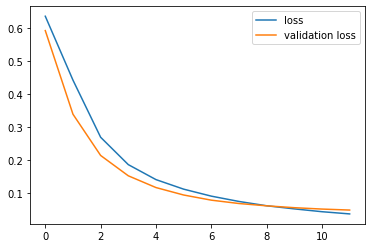

In [85]:
# check out training curve
# not only loss, but also validation_loss
plt.plot(results.history["loss"],label="loss")
plt.plot(results.history["val_loss"],label="validation loss")
plt.legend()
plt.show()

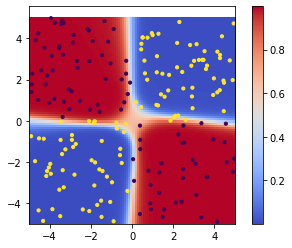

In [118]:
def binary_preds(model, x_minmax=5):
    x_grid = np.linspace(-x_minmax, x_minmax, 100)
    mesh = np.meshgrid(x_grid, x_grid)
    xs_grid = np.stack(mesh, axis=-1)
    yhat = model(xs_grid).numpy().squeeze()
    
    plt.imshow(yhat, cmap='coolwarm', extent=[-x_minmax, x_minmax, -x_minmax, x_minmax]) 
    #use extent to change values (labels) of imshow
    plt.colorbar()

binary_preds(model)
plt.scatter(x_train[:, 0], x_train[:, 1], s=10, c=y_train, cmap='viridis')
plt.show()

### general classfication

Finally we will download and train on some real data to learn about general classification. Here is some code that will download and show some metadata about the MNIST dataset -- a collectin of handwritten digits.

Update your model to work on this data so that you model can predict the digit from its image. One new thing to keep in mind: these inputs are 2D. Later in the course we will learn about convolutional neural nets for handing such inputs more naturally, but for now, update your `tfkl.Input` layer to be 2-dimensional and then add a `tfkl.Flatten()` layer right after it to unravel the 2-d image into a 1-d vector of pixels.

Again, visualalizing the output is a bit tricky, so we have provided some code to help.

In [119]:
import tensorflow_datasets as tfds

ds, metadata = tfds.load('mnist', with_info=True)
print(metadata)

tfds.core.DatasetInfo(
    name='mnist',
    version=3.0.1,
    description='The MNIST database of handwritten digits.',
    homepage='http://yann.lecun.com/exdb/mnist/',
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=70000,
    splits={
        'test': 10000,
        'train': 60000,
    },
    supervised_keys=('image', 'label'),
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
    redistribution_info=,
)



In [123]:
# your code here
a = tf.nn.softplus
model = tfk.Sequential([
    tfkl.Input((28, 28)),
    tfkl.Flatten(),
    tfkl.Dense(100, activation = a),
    tfkl.Dense(20, activation = a),
    tfkl.Dense(10,activation =tf.nn.softmax) #10 outputs for hand-written 0-9
])

model.summary()

model.compile(optimizer = tfk.optimizers.Adam(), loss = tfk.losses.SparseCategoricalCrossentropy())
#difference between categoricalCrossEntropy and SparseCategoricalCrossentropy is : if your target is int/one-hot vector
#SparseCategoricalCrossentropy: y value is 0-9
#categoricalCrossEntropy: y value is a vector adds up to 1

cbs = [tfk.callbacks.EarlyStopping(min_delta = 0.01, patience = 1)]

preprocess = lambda d:(tf.cast(d['image'], tf.float32)/255., d['label']) # standardize the data to 0-1, so in reasonable range for input layer
#take a dictionary; x value is color, y value is label
ds_train = ds['train'].map(preprocess).cache().repeat().batch(32).repeat().prefetch(10)
ds_test =  ds['test'].take(1000).map(preprocess).repeat().batch(1000).repeat().prefetch(10)

result = model.fit(ds_train, steps_per_epoch = 100, epochs = 1000, callbacks= cbs,
               validation_data = ds_test, validation_steps = 1)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 100)               78500     
_________________________________________________________________
dense_22 (Dense)             (None, 20)                2020      
_________________________________________________________________
dense_23 (Dense)             (None, 10)                210       
Total params: 80,730
Trainable params: 80,730
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
100/100 [==============================] - 0s 5ms/step - loss: 1.3320 - val_loss: 0.5434
Epoch 2/1000
100/100 [==============================] - 0s 3ms/step - loss: 0.5061 - val_loss: 0.3844
Epoch 3/1000
100/100 [======================

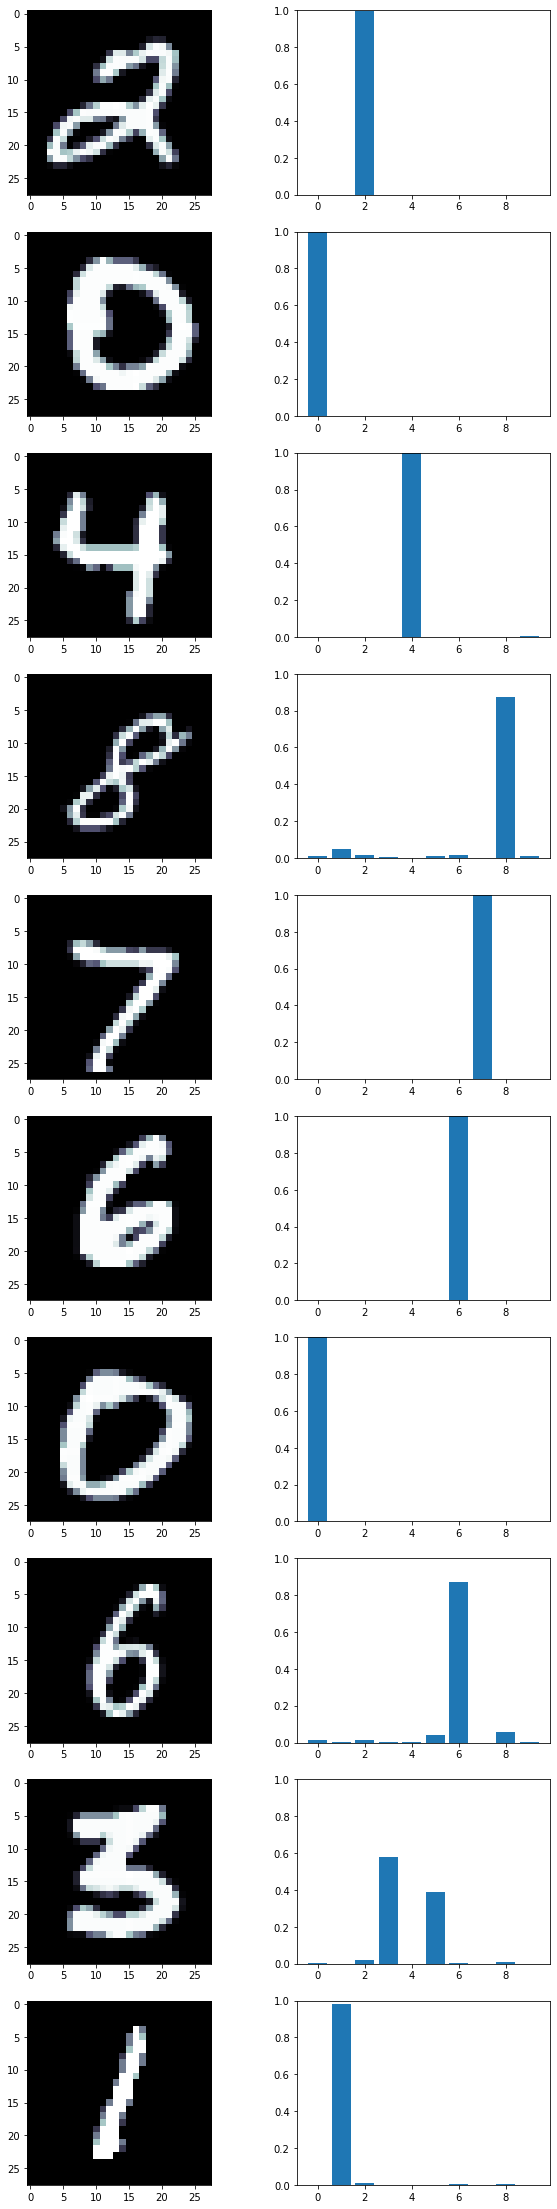

In [132]:
def mnist_viz(model):
    ims, labels = next(iter(ds_test)) # ims,labels are x value and y value seperately
    #ims, labels = next(iter(ds['test'].map(preprocess).batch(10)))
    yhat = model(ims)
    ypred = tf.argmax(yhat)
    
    plt.figure(figsize=(10, 40))
    for i in range(10):
        plt.subplot(10, 2, 2*i+1)
        plt.imshow(ims[i].numpy().squeeze(), cmap='bone')
        plt.subplot(10, 2, 2*i+2)
        plt.bar(np.arange(10), yhat[i].numpy())
        plt.ylim([0, 1])
    plt.show()

# your code here
mnist_viz(model)